### Handwritten Signature Forgery Detection Using Deep Learning

In [1]:
from torchvision import transforms
import torch
import torch.optim as optim
from torchvision import datasets, transforms

import torchvision
import numpy as np
import os


In [2]:
%matplotlib inline
data_dir = 'signatures'
genuine_dir = os.path.join(data_dir, 'full_org')
forged_dir = os.path.join(data_dir, 'full_forg')

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
data = datasets.ImageFolder(root=data_dir, transform=transform)
data_length = len(data)

print(data_length)

2640


In [3]:
problematic_files = []

for idx in range(len(data)):
    try:
        img, label = data[idx]
    except Exception as e:
        problematic_files.append((data.imgs[idx], str(e)))

if problematic_files:
    print(f"Found {len(problematic_files)} missing data:")
    for file_info in problematic_files:
        print(file_info)
else:
    print("No missing files found.")

print(f"Total number of images: {len(data)}")

No missing files found.
Total number of images: 2640


In [4]:
from collections import Counter

class_counts = Counter() 
for _, label in data:
    class_counts[label] += 1

for label_idx, count in class_counts.items():
    class_name = data.classes[label_idx]
    print(f'Class: {class_name}, Count: {count}')

Class: full_forg, Count: 1320
Class: full_org, Count: 1320


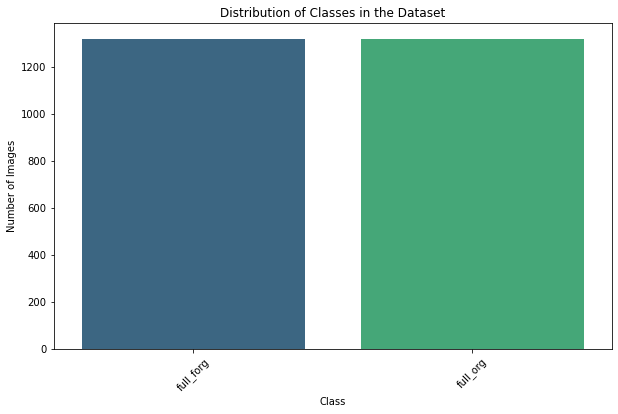

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = data.classes
class_counts = Counter([label for _, label in data.imgs])

labels, counts = zip(*class_counts.items())
class_labels = [class_names[label] for label in labels]


plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_labels), y=list(counts), hue=list(class_labels), palette='viridis', legend=False)
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

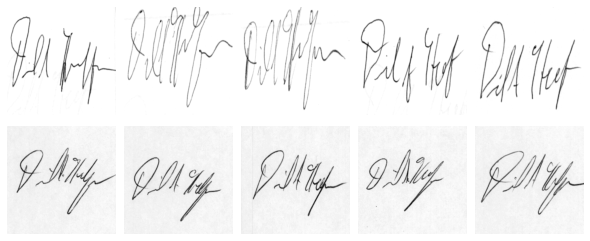

In [6]:
def show_images_by_class(data, n_images=5):
    _, axs = plt.subplots(2, n_images, figsize=(n_images * 2, 2 * 2))
    for class_idx in range(2):
        class_images = [img for img, label in data if label == class_idx]
        for img_idx in range(n_images):
            axs[class_idx, img_idx].imshow(class_images[img_idx][0], cmap='gray')
            axs[class_idx, img_idx].axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()
    
show_images_by_class(data)

In [7]:
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(data, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Training Images


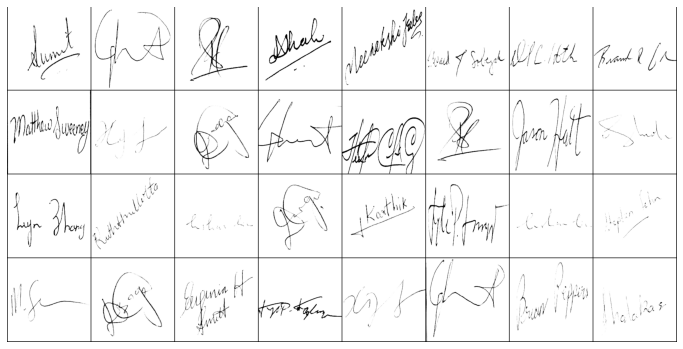

--------------------
Sample Validation Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


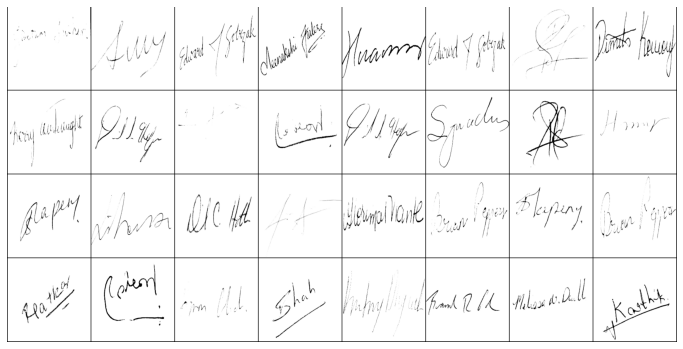

--------------------
Sample Testing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


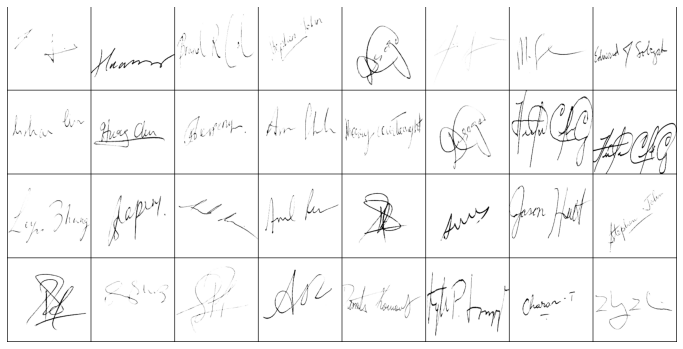

--------------------


In [8]:
def show_batch(images, figsize=(10, 10)):
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
print("Sample Training Images")
show_batch(images, figsize=(12, 12))
print("--------------------")

images, labels = next(iter(val_loader))
print("Sample Validation Images")
show_batch(images, figsize=(12, 12))
print("--------------------")

images, labels = next(iter(test_loader))
print("Sample Testing Images")
show_batch(images, figsize=(12, 12))
print("--------------------")

### CNN Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_losses, val_losses, train_acc, val_acc

train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Train Loss: 0.6406, Train Acc: 0.6909, Val Loss: 0.2297, Val Acc: 0.9621
Epoch [2/10], Train Loss: 0.1975, Train Acc: 0.9199, Val Loss: 0.0739, Val Acc: 0.9848
Epoch [3/10], Train Loss: 0.1830, Train Acc: 0.9388, Val Loss: 0.1514, Val Acc: 0.9596
Epoch [4/10], Train Loss: 0.0793, Train Acc: 0.9773, Val Loss: 2.6982, Val Acc: 0.5177
Epoch [5/10], Train Loss: 0.5481, Train Acc: 0.8343, Val Loss: 0.1473, Val Acc: 0.9621
Epoch [6/10], Train Loss: 0.0413, Train Acc: 0.9913, Val Loss: 0.0462, Val Acc: 0.9848
Epoch [7/10], Train Loss: 0.0086, Train Acc: 1.0000, Val Loss: 0.0276, Val Acc: 0.9924
Epoch [8/10], Train Loss: 0.0063, Train Acc: 0.9995, Val Loss: 0.0207, Val Acc: 0.9924
Epoch [9/10], Train Loss: 0.0016, Train Acc: 1.0000, Val Loss: 0.0417, Val Acc: 0.9848
Epoch [10/10], Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.0184, Val Acc: 0.9899


In [11]:
from sklearn.metrics import precision_recall_fscore_support

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return accuracy, precision, recall, f1

test_accuracy, test_precision, test_recall, test_f1 = test_model(model, test_loader)


Test Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F1 Score: 0.9975


### OPTIMISED CNN MODEL

In [12]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2), 
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [13]:
data_aug = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(data_aug))
val_size = int(0.15 * len(data_aug))
test_size = len(data_aug) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(data_aug, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


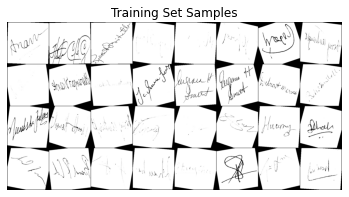

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


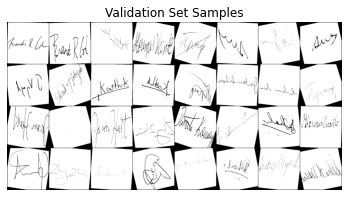

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


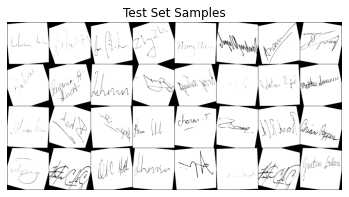

In [14]:
def show_samples(loader, title):
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images)
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_samples(train_loader, "Training Set Samples")
show_samples(val_loader, "Validation Set Samples")
show_samples(test_loader, "Test Set Samples")

In [15]:
class CNetOptimised(nn.Module):
    def __init__(self):
        super(CNetOptimised, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model_aug = CNetOptimised()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)



In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_losses, val_losses, train_acc, val_acc

train_losses, val_losses, train_acc, val_acc = train_model(model_aug, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Train Loss: 0.8655, Train Acc: 0.5452, Val Loss: 0.6375, Val Acc: 0.6717
Epoch [2/10], Train Loss: 0.6230, Train Acc: 0.6551, Val Loss: 0.6177, Val Acc: 0.6490
Epoch [3/10], Train Loss: 0.6043, Train Acc: 0.6779, Val Loss: 0.5752, Val Acc: 0.6995
Epoch [4/10], Train Loss: 0.5917, Train Acc: 0.6930, Val Loss: 0.5526, Val Acc: 0.7323
Epoch [5/10], Train Loss: 0.5783, Train Acc: 0.6887, Val Loss: 0.5307, Val Acc: 0.7273
Epoch [6/10], Train Loss: 0.5869, Train Acc: 0.6881, Val Loss: 0.5342, Val Acc: 0.7475
Epoch [7/10], Train Loss: 0.5693, Train Acc: 0.7033, Val Loss: 0.5293, Val Acc: 0.7576
Epoch [8/10], Train Loss: 0.5689, Train Acc: 0.6990, Val Loss: 0.4984, Val Acc: 0.7803
Epoch [9/10], Train Loss: 0.5581, Train Acc: 0.7158, Val Loss: 0.5046, Val Acc: 0.7475
Epoch [10/10], Train Loss: 0.5519, Train Acc: 0.7195, Val Loss: 0.4888, Val Acc: 0.7702


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

def test_optimised_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    y_true = []
    y_pred = []
    y_scores = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
            y_true.extend(targets.numpy())
            y_pred.extend(predicted.numpy())
            y_scores.extend(outputs.numpy())
    
    test_loss /= total_test
    accuracy_test = 100 * correct_test / total_test
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy_test:.2f}%')
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


    return y_true, y_pred, y_scores, accuracy_test, test_loss
    
y_true, y_pred, y_scores, c, test_loss = test_optimised_model(model_aug, test_loader, criterion)

Test Loss: 0.5294, Test Accuracy: 73.55%
Precision: 0.74
Recall: 0.74
F1 Score: 0.73


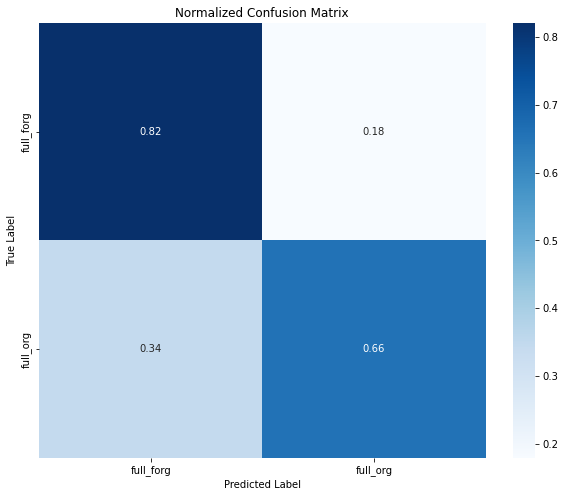

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='.2f')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

class_names = data.classes
plot_confusion_matrix(y_true, y_pred, class_names)

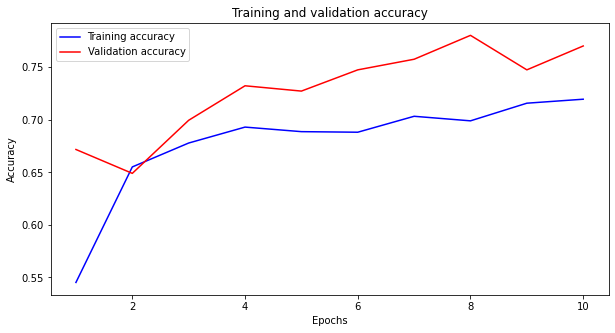

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc, val_acc)

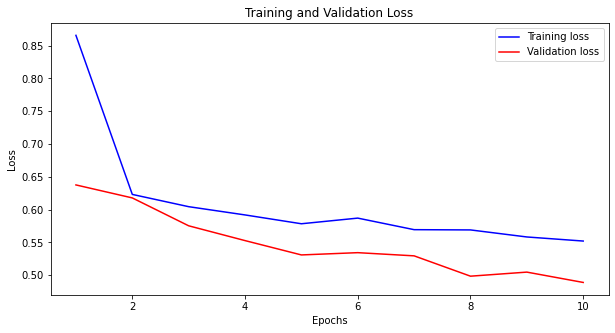

In [20]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_loss(train_losses, val_losses)

In [21]:
%matplotlib inline

Using device: cuda
torch.Size([32, 1, 224, 224]) torch.Size([32])


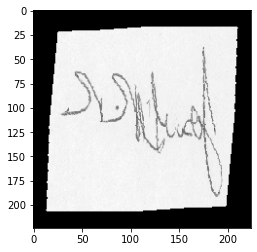

torch.Size([32, 1, 224, 224]) torch.Size([32])


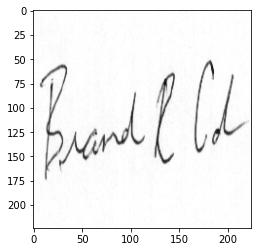

In [22]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
base_dir = 'signatures'
forg_dir = os.path.join(base_dir, 'full_forg')
org_dir = os.path.join(base_dir, 'full_org')

# Custom dataset class
class SignatureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise RuntimeError(f"Error reading image {self.image_paths[idx]}")
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis=2)  # Add channel dimension
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Verify Data Loader
def verify_data_loader(loader):
    for images, labels in loader:
        print(images.shape, labels.shape)
        plt.imshow(images[0].numpy().squeeze(), cmap='gray')
        plt.show()
        break



# Function to load images and labels by person
def load_images_and_labels_by_person(forg_dir, org_dir):
    images = []
    labels = []
    person_ids = []

    for filename in os.listdir(forg_dir):
        if filename.endswith('.png'):
            person_id = int(filename.split('_')[1])
            images.append(os.path.join(forg_dir, filename))
            labels.append(1)  # Forged label
            person_ids.append(person_id)

    for filename in os.listdir(org_dir):
        if filename.endswith('.png'):
            person_id = int(filename.split('_')[1])
            images.append(os.path.join(org_dir, filename))
            labels.append(0)  # Original label
            person_ids.append(person_id)

    return images, labels, person_ids

images, labels, person_ids = load_images_and_labels_by_person(forg_dir, org_dir)

# Split the person_ids into train, validation, and test sets
unique_person_ids = list(set(person_ids))
train_person_ids, test_person_ids = train_test_split(unique_person_ids, test_size=0.2, random_state=42)
train_person_ids, val_person_ids = train_test_split(train_person_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Function to filter images and labels by person_ids
def filter_by_person_ids(images, labels, person_ids, target_person_ids):
    filtered_images = []
    filtered_labels = []
    for img, label, pid in zip(images, labels, person_ids):
        if pid in target_person_ids:
            filtered_images.append(img)
            filtered_labels.append(label)
    return filtered_images, filtered_labels

# Filter images and labels for each split
train_images, train_labels = filter_by_person_ids(images, labels, person_ids, train_person_ids)
val_images, val_labels = filter_by_person_ids(images, labels, person_ids, val_person_ids)
test_images, test_labels = filter_by_person_ids(images, labels, person_ids, test_person_ids)

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Datasets and DataLoaders
train_dataset = SignatureDataset(train_images, train_labels, transform=train_transform)
val_dataset = SignatureDataset(val_images, val_labels, transform=transform)
test_dataset = SignatureDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

verify_data_loader(train_loader)
verify_data_loader(val_loader)


### AlexNet Model

In [23]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_alex = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_alex = optim.Adam(model_alex.parameters(), lr=0.0001)

In [24]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

num_epochs = 20
train_losses_alex, val_losses_alex = [], []
train_accuracies_alex, val_accuracies_alex = [], []

for epoch in range(num_epochs):
    train_loss_alex, train_accuracy_alex = train(model_alex, train_loader, criterion, optimizer_alex, device)
    val_loss_alex, val_accuracy_alex = validate(model_alex, val_loader, criterion, device)
    
    train_losses_alex.append(train_loss_alex)
    val_losses_alex.append(val_loss_alex)
    train_accuracies_alex.append(train_accuracy_alex)
    val_accuracies_alex.append(val_accuracy_alex)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss_alex:.4f}, Train Accuracy: {train_accuracy_alex:.4f}, '
          f'Val Loss: {val_loss_alex:.4f}, Val Accuracy: {val_accuracy_alex:.4f}')


Epoch [1/20], Train Loss: 0.6943, Train Accuracy: 0.5126, Val Loss: 0.6941, Val Accuracy: 0.5000
Epoch [2/20], Train Loss: 0.6949, Train Accuracy: 0.4867, Val Loss: 0.6927, Val Accuracy: 0.5000
Epoch [3/20], Train Loss: 0.6933, Train Accuracy: 0.5032, Val Loss: 0.6910, Val Accuracy: 0.5000
Epoch [4/20], Train Loss: 0.6789, Train Accuracy: 0.5669, Val Loss: 0.6287, Val Accuracy: 0.6553
Epoch [5/20], Train Loss: 0.6437, Train Accuracy: 0.6313, Val Loss: 0.6015, Val Accuracy: 0.6932
Epoch [6/20], Train Loss: 0.6288, Train Accuracy: 0.6439, Val Loss: 0.5752, Val Accuracy: 0.6951
Epoch [7/20], Train Loss: 0.6175, Train Accuracy: 0.6585, Val Loss: 0.5406, Val Accuracy: 0.7443
Epoch [8/20], Train Loss: 0.5925, Train Accuracy: 0.6793, Val Loss: 0.5086, Val Accuracy: 0.7519
Epoch [9/20], Train Loss: 0.5602, Train Accuracy: 0.7222, Val Loss: 0.4801, Val Accuracy: 0.7708
Epoch [10/20], Train Loss: 0.5638, Train Accuracy: 0.7039, Val Loss: 0.5481, Val Accuracy: 0.6837
Epoch [11/20], Train Loss: 0.

In [25]:
model_alex.eval()
test_correct_alex = 0
test_total_alex = 0
test_loss_alex = 0.0
all_labels_alex = []
all_predictions_alex = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_alex(images)
        loss = criterion(outputs, labels)
        
        test_loss_alex += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        
        test_total_alex += labels.size(0)
        test_correct_alex += (predicted == labels).sum().item()
        
        all_labels_alex.extend(labels.cpu().numpy())
        all_predictions_alex.extend(predicted.cpu().numpy())

test_loss_alex /= test_total_alex
test_accuracy_alex = test_correct_alex / test_total_alex
print(f'Test Loss: {test_loss_alex:.4f}, Test Accuracy: {test_accuracy_alex:.4f}')


Test Loss: 0.4190, Test Accuracy: 0.7992


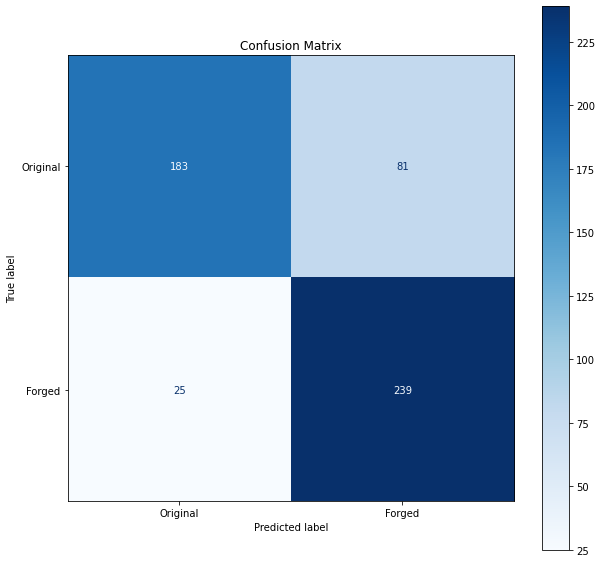

In [26]:
cm = confusion_matrix(all_labels_alex, all_predictions_alex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Original', 'Forged'])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

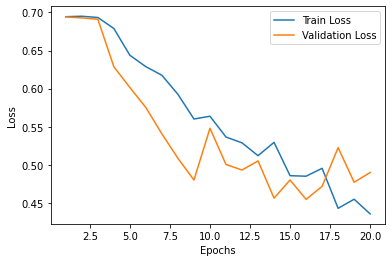

In [27]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses_alex, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses_alex, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

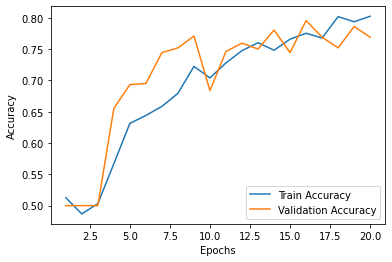

In [28]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies_alex, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies_alex, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### ResNet50 Model

In [29]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted for single-channel input
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

model_res = ResNet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(model_res.parameters(), lr=0.0001, weight_decay=1e-4)

In [30]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

num_epochs = 20
train_losses_res, val_losses_res = [], []
train_accuracies_res, val_accuracies_res = [], []

for epoch in range(num_epochs):
    train_loss_res, train_accuracy_res = train(model_res, train_loader, criterion, optimizer_res, device)
    val_loss_res, val_accuracy_res = validate(model_res, val_loader, criterion, device)
    
    train_losses_res.append(train_loss_res)
    val_losses_res.append(val_loss_res)
    train_accuracies_res.append(train_accuracy_res)
    val_accuracies_res.append(val_accuracy_res)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss_res:.4f}, Train Accuracy: {train_accuracy_res:.4f}, '
          f'Val Loss: {val_loss_res:.4f}, Val Accuracy: {val_accuracy_res:.4f}')


Epoch [1/20], Train Loss: 0.7257, Train Accuracy: 0.5688, Val Loss: 3.1771, Val Accuracy: 0.5000
Epoch [2/20], Train Loss: 0.6209, Train Accuracy: 0.6787, Val Loss: 0.6502, Val Accuracy: 0.6420
Epoch [3/20], Train Loss: 0.4819, Train Accuracy: 0.7652, Val Loss: 1.1785, Val Accuracy: 0.5208
Epoch [4/20], Train Loss: 0.4436, Train Accuracy: 0.7784, Val Loss: 0.4088, Val Accuracy: 0.7936
Epoch [5/20], Train Loss: 0.4353, Train Accuracy: 0.7885, Val Loss: 0.4222, Val Accuracy: 0.7708
Epoch [6/20], Train Loss: 0.4159, Train Accuracy: 0.8106, Val Loss: 0.4583, Val Accuracy: 0.7803
Epoch [7/20], Train Loss: 0.4019, Train Accuracy: 0.8163, Val Loss: 0.6436, Val Accuracy: 0.6723
Epoch [8/20], Train Loss: 0.3659, Train Accuracy: 0.8314, Val Loss: 0.4992, Val Accuracy: 0.7614
Epoch [9/20], Train Loss: 0.3671, Train Accuracy: 0.8384, Val Loss: 0.6862, Val Accuracy: 0.7178
Epoch [10/20], Train Loss: 0.3377, Train Accuracy: 0.8504, Val Loss: 1.0302, Val Accuracy: 0.4261
Epoch [11/20], Train Loss: 0.

In [31]:
model_res.eval()
test_correct_res = 0
test_total_res = 0
test_loss_res = 0.0
all_labels_res = []
all_predictions_res = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_res(images)
        loss = criterion(outputs, labels)
        
        test_loss_res += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        
        test_total_res += labels.size(0)
        test_correct_res += (predicted == labels).sum().item()
        
        all_labels_res.extend(labels.cpu().numpy())
        all_predictions_res.extend(predicted.cpu().numpy())

test_loss_res /= test_total_res
test_accuracy_res = test_correct_res / test_total_res
print(f'Test Loss: {test_loss_res:.4f}, Test Accuracy: {test_accuracy_res:.4f}')


Test Loss: 0.1001, Test Accuracy: 0.9583


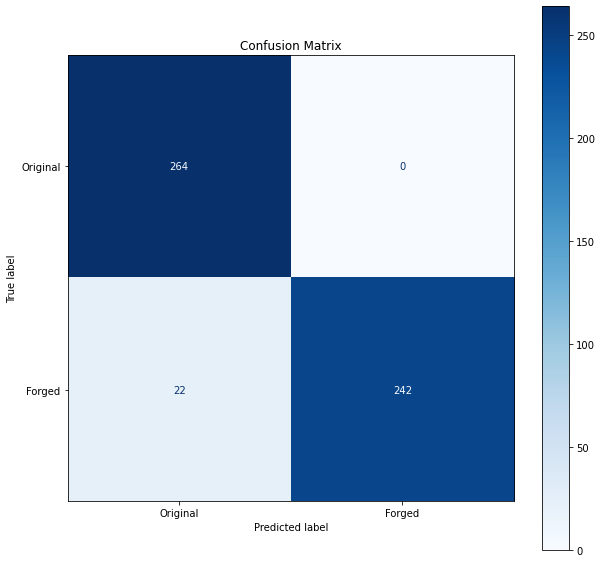

In [32]:
cm = confusion_matrix(all_labels_res, all_predictions_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Original', 'Forged'])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

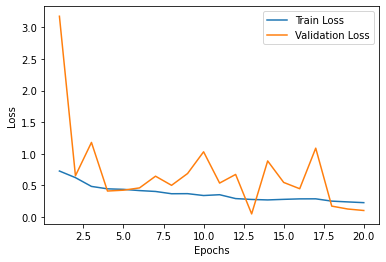

In [33]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses_res, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses_res, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

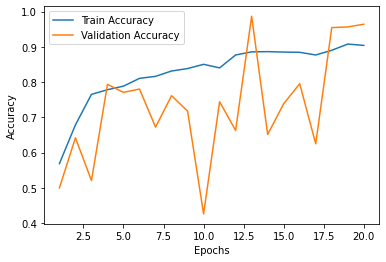

In [34]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies_res, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies_res, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG19 Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class VGG19Model(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19Model, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model_vgg19 = VGG19Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg19.parameters(), lr=0.0001, weight_decay=1e-4)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model_vgg19.apply(weights_init)


VGG19Model(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(1

In [36]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model_vgg19, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model_vgg19, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/15], Train Loss: 4.2237, Train Accuracy: 0.5290, Val Loss: 4.6344, Val Accuracy: 0.5000
Epoch [2/15], Train Loss: 2.1721, Train Accuracy: 0.5486, Val Loss: 0.9017, Val Accuracy: 0.5208
Epoch [3/15], Train Loss: 2.0040, Train Accuracy: 0.5379, Val Loss: 0.7455, Val Accuracy: 0.5000
Epoch [4/15], Train Loss: 1.1679, Train Accuracy: 0.5404, Val Loss: 0.6800, Val Accuracy: 0.5038
Epoch [5/15], Train Loss: 1.5018, Train Accuracy: 0.5379, Val Loss: 0.8215, Val Accuracy: 0.5019
Epoch [6/15], Train Loss: 1.2621, Train Accuracy: 0.5398, Val Loss: 0.6564, Val Accuracy: 0.6534
Epoch [7/15], Train Loss: 1.0964, Train Accuracy: 0.5455, Val Loss: 0.7208, Val Accuracy: 0.7992
Epoch [8/15], Train Loss: 0.9284, Train Accuracy: 0.6054, Val Loss: 0.4138, Val Accuracy: 0.8977
Epoch [9/15], Train Loss: 0.8738, Train Accuracy: 0.6951, Val Loss: 0.6497, Val Accuracy: 0.5928
Epoch [10/15], Train Loss: 0.7114, Train Accuracy: 0.7386, Val Loss: 0.5177, Val Accuracy: 0.8428
Epoch [11/15], Train Loss: 0.

In [37]:
model_vgg19.eval()
test_correct = 0
test_total = 0
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_vgg19(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= test_total
test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1891, Test Accuracy: 0.9432


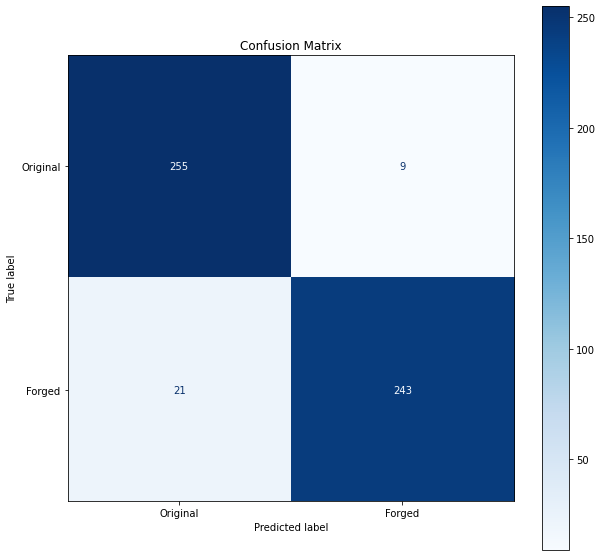

In [38]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Original', 'Forged'])

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

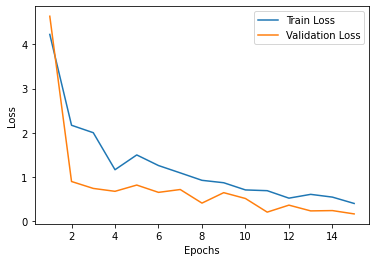

In [39]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

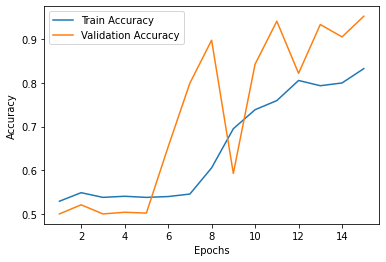

In [40]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Optimised Preprocessing on ResNet50 and VGG19

In [1]:
%matplotlib inline

In [9]:
import os
import pickle
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the paths to your dataset
base_path_org = 'signatures/full_org/original_%d_%d.png'
base_path_forg = 'signatures/full_forg/forgeries_%d_%d.png'

# Define the image transformations for ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Generate the dataset
data = []
n_samples_of_each_class = 13500

for _ in range(n_samples_of_each_class):
    person = random.randrange(1, 55)
    org_sign = random.randrange(1, 24)
    forg_sign = random.randrange(1, 24)
    
    original = [base_path_org % (person, org_sign), 1]  # label 1 for original
    forgery = [base_path_forg % (person, forg_sign), 0]  # label 0 for forgery
    
    data.append(original)
    data.append(forgery)

# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.15)

# Save the indices
with open('train_index.pkl', 'wb') as train_index_file:
    pickle.dump(train, train_index_file)

with open('test_index.pkl', 'wb') as test_index_file:
    pickle.dump(test, test_index_file)

# Custom Dataset class
class SignaturesDataset(Dataset):
    def __init__(self, index_file):
        with open(index_file, 'rb') as f:
            self.data = pickle.load(f)

    def __getitem__(self, index):
        item = self.data[index]
        img = Image.open(item[0]).convert('RGB')
        img = transform(img)
        label = torch.tensor(item[1], dtype=torch.long)
        return img, label

    def __len__(self):
        return len(self.data)

# Create datasets and data loaders
train_dataset = SignaturesDataset('train_index.pkl')
test_dataset = SignaturesDataset('test_index.pkl')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Bottleneck block
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define ResNet50 model from scratch
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Instantiate the model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Testing the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 0.0238
Epoch [2/10], Loss: 0.0077
Epoch [3/10], Loss: 0.0150
Epoch [4/10], Loss: 0.0380
Epoch [5/10], Loss: 0.0084
Epoch [6/10], Loss: 0.0019
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0145
Epoch [10/10], Loss: 0.0016
Accuracy: 100.00%


In [11]:
# Testing the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 100.00%


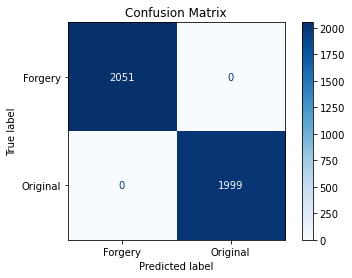

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Forgery', 'Original'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Define a custom VGG19 model with dropout
class VGG19WithDropout(nn.Module):
    def __init__(self):
        super(VGG19WithDropout, self).__init__()
        self.vgg = models.vgg19_bn(pretrained=True)  # Use the VGG19 model with batch normalization
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.vgg(x)

# Instantiate the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG19WithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Testing the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /user/akesanur/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.p

  0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch [1/10], Loss: 0.0810
Epoch [2/10], Loss: 0.0119
Epoch [3/10], Loss: 0.0037
Epoch [4/10], Loss: 0.0164
Epoch [5/10], Loss: 0.0146
Epoch [6/10], Loss: 0.0035
Epoch [7/10], Loss: 0.1506
Epoch [8/10], Loss: 0.0167
Epoch [9/10], Loss: 0.0035
Epoch [10/10], Loss: 0.0130
Accuracy: 100.00%


### Siamese Model

In [41]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Paths to the datasets
root_dir = 'signatures'
genuine_dir = os.path.join(root_dir, 'full_org')
forged_dir = os.path.join(root_dir, 'full_forg')

# Get lists of all genuine and forged images
all_genuine_images = [f for f in os.listdir(genuine_dir) if f.endswith('.png')]
all_forged_images = [f for f in os.listdir(forged_dir) if f.endswith('.png')]

# Function to group images by person ID
def group_images_by_person(image_list):
    grouped_images = defaultdict(list)
    for img in image_list:
        person_id = img.split('_')[1]
        grouped_images[person_id].append(img)
    return grouped_images

# Group the images by person ID
genuine_images_by_person = group_images_by_person(all_genuine_images)
forged_images_by_person = group_images_by_person(all_forged_images)

# Get list of person IDs
person_ids = list(genuine_images_by_person.keys())

# Split person IDs into training, validation, and test sets
train_person_ids, test_person_ids = train_test_split(person_ids, test_size=0.2, random_state=42)
train_person_ids, val_person_ids = train_test_split(train_person_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Function to get images for a list of person IDs
def get_images_for_person_ids(person_ids, images_by_person):
    images = []
    for person_id in person_ids:
        images.extend(images_by_person[person_id])
    return images

# Get training, validation, and test images
train_genuine_images = get_images_for_person_ids(train_person_ids, genuine_images_by_person)
val_genuine_images = get_images_for_person_ids(val_person_ids, genuine_images_by_person)
test_genuine_images = get_images_for_person_ids(test_person_ids, genuine_images_by_person)

train_forged_images = get_images_for_person_ids(train_person_ids, forged_images_by_person)
val_forged_images = get_images_for_person_ids(val_person_ids, forged_images_by_person)
test_forged_images = get_images_for_person_ids(test_person_ids, forged_images_by_person)

# Define the dataset class
class SignatureDataset(Dataset):
    def __init__(self, genuine_images, forged_images, root_dir, transform=None):
        self.genuine_images = genuine_images
        self.forged_images = forged_images
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.genuine_images), len(self.forged_images)) * 2  # Balanced pairs

    def __getitem__(self, idx):
        if idx % 2 == 0:  # This creates a pair of genuine images (label 0)
            img1_path = os.path.join(self.root_dir, 'full_org', self.genuine_images[idx // 2])
            person_id = self.genuine_images[idx // 2].split('_')[1]
            img2_path = os.path.join(self.root_dir, 'full_org', np.random.choice(genuine_images_by_person[person_id]))
            label = 0
        else:  # This creates a pair of one genuine and one forged image (label 1)
            img1_path = os.path.join(self.root_dir, 'full_org', self.genuine_images[idx // 2])
            person_id = self.genuine_images[idx // 2].split('_')[1]
            img2_path = os.path.join(self.root_dir, 'full_forg', np.random.choice(forged_images_by_person[person_id]))
            label = 1

        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

# Define the transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),  # Reduced rotation angle
    transforms.RandomAffine(0, shear=5, scale=(0.9, 1.1)),  # Reduced shear and scale
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Reduced jitter
    transforms.RandomGrayscale(p=0.1),  # Reduced probability
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and data loaders
train_dataset = SignatureDataset(train_genuine_images, train_forged_images, root_dir, train_transform)
val_dataset = SignatureDataset(val_genuine_images, val_forged_images, root_dir, transform)
test_dataset = SignatureDataset(test_genuine_images, test_forged_images, root_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True)
        )

        # Calculate the output size after the convolutional layers
        self._initialize_weights()
        dummy_input = torch.randn(1, 1, 128, 128)
        output_size = self.cnn(dummy_input).view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(output_size, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output1 = output1.view(output1.size()[0], -1)
        output1 = self.fc(output1)

        output2 = self.cnn(x2)
        output2 = output2.view(output2.size()[0], -1)
        output2 = self.fc(output2)

        return output1, output2

# Instantiate the network
siamese_net = SiameseNetwork().cuda()  # Move to GPU if available

# Define the Loss Function and Optimizer
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Instantiate the loss function
criterion = ContrastiveLoss().cuda()
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=0.0001)



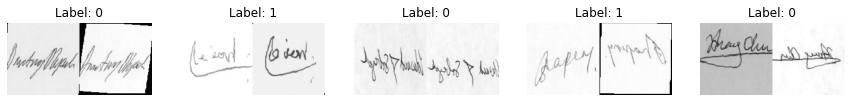

In [46]:
# Visualize a few samples from the dataset
def visualize_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))

    for i, idx in enumerate(indices):
        img1, img2, label = dataset[idx]
        img1 = img1.numpy().transpose((1, 2, 0)).squeeze()
        img2 = img2.numpy().transpose((1, 2, 0)).squeeze()
        combined_img = np.concatenate((img1, img2), axis=1)
        axes[i].imshow(combined_img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.show()

# Visualize a few samples from the training dataset
visualize_samples(train_dataset, num_samples=5)

In [47]:
# Training Loop
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
        
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance > 0.5).float()
        correct += (predictions == label).sum().item()
        total += label.size(0)
        
        if batch_idx % 100 == 99:
            print(f'Epoch [{epoch+1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label.float())
            running_loss += loss.item()
            
            # Calculate accuracy
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance > 0.5).float()
            correct += (predictions == label).sum().item()
            total += label.size(0)
    
    accuracy = 100 * correct / total
    return running_loss / len(val_loader), accuracy

# Training and Validation
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(siamese_net, train_loader, criterion, optimizer, epoch)
    val_loss, val_accuracy = validate(siamese_net, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')



Epoch [1/10], Training Loss: 0.3450, Training Accuracy: 54.42%, Validation Loss: 0.3100, Validation Accuracy: 55.87%
Epoch [2/10], Training Loss: 0.2803, Training Accuracy: 60.98%, Validation Loss: 0.3357, Validation Accuracy: 53.22%
Epoch [3/10], Training Loss: 0.2739, Training Accuracy: 62.18%, Validation Loss: 0.3431, Validation Accuracy: 54.55%
Epoch [4/10], Training Loss: 0.2611, Training Accuracy: 64.77%, Validation Loss: 0.3308, Validation Accuracy: 56.44%
Epoch [5/10], Training Loss: 0.2587, Training Accuracy: 64.33%, Validation Loss: 0.3419, Validation Accuracy: 54.17%
Epoch [6/10], Training Loss: 0.2600, Training Accuracy: 63.26%, Validation Loss: 0.3335, Validation Accuracy: 54.92%
Epoch [7/10], Training Loss: 0.2630, Training Accuracy: 64.20%, Validation Loss: 0.3356, Validation Accuracy: 54.92%
Epoch [8/10], Training Loss: 0.2585, Training Accuracy: 64.14%, Validation Loss: 0.3281, Validation Accuracy: 55.30%
Epoch [9/10], Training Loss: 0.2584, Training Accuracy: 63.64%, 

Accuracy: 0.6136
Precision: 0.6786
Recall: 0.4318
F1 Score: 0.5278
Confusion Matrix:
[[210  54]
 [150 114]]


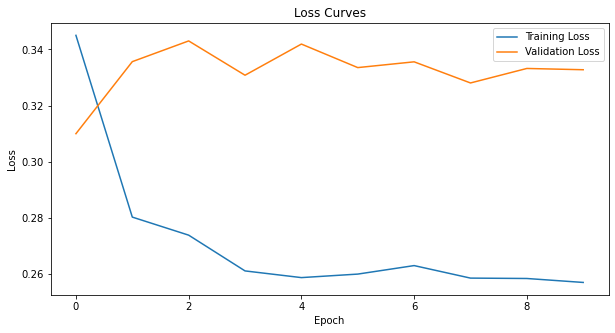

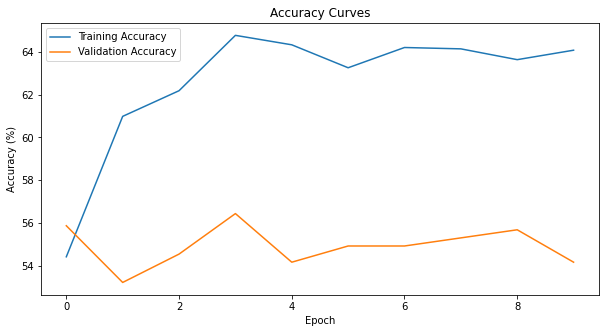

In [48]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance > 0.5).float()
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate(siamese_net, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{cm}')

# Plotting the Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plotting the Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.show()



### GAN image generation

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 128 * 128),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1, 128, 128)
        return x

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128 * 128, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

# Initialize the models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Loss and optimizers
criterion = nn.BCELoss()
lr = 0.0002
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)


In [73]:
# Hyperparameters
num_epochs = 200
batch_size = 64
latent_dim = 100

# Data loader for training GAN
class GANImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

gan_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

genuine_image_paths = [os.path.join(genuine_dir, img) for img in all_genuine_images]
gan_dataset = GANImageDataset(genuine_image_paths, gan_transform)
gan_loader = DataLoader(gan_dataset, batch_size=batch_size, shuffle=True)

# Training the GAN
for epoch in range(num_epochs):
    for i, images in enumerate(gan_loader):
        # Prepare real and fake images
        real_images = images.cuda()
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1).cuda()
        labels_fake = torch.zeros(batch_size, 1).cuda()

        # Train Discriminator
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, labels_real)

        z = torch.randn(batch_size, latent_dim).cuda()
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        d_loss_fake = criterion(outputs, labels_fake)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).cuda()
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, labels_real)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

print("Training completed!")


Epoch [20/200], d_loss: 0.8820, g_loss: 0.4548
Epoch [40/200], d_loss: 0.6022, g_loss: 1.1896
Epoch [60/200], d_loss: 0.0190, g_loss: 7.2000
Epoch [80/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [100/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [120/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [140/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [160/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [180/200], d_loss: 100.0000, g_loss: 0.0000
Epoch [200/200], d_loss: 100.0000, g_loss: 0.0000
Training completed!


In [74]:
# Generate new images
num_images_to_generate = 1000
generated_images = []
generator.eval()

with torch.no_grad():
    for _ in range(num_images_to_generate // batch_size):
        z = torch.randn(batch_size, latent_dim).cuda()
        fake_images = generator(z)
        fake_images = fake_images.cpu().numpy()
        generated_images.extend(fake_images)

# Save the generated images
generated_image_dir = 'generated_images'
os.makedirs(generated_image_dir, exist_ok=True)

for i, img in enumerate(generated_images):
    img = (img.squeeze() * 0.5 + 0.5) * 255  # Denormalize
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img.save(os.path.join(generated_image_dir, f'generated_{i}.png'))

print("Generated images saved!")


Generated images saved!


Epoch [1/10], Training Loss: 0.2745, Training Accuracy: 60.67%, Validation Loss: 0.3266, Validation Accuracy: 55.30%
Epoch [2/10], Training Loss: 0.2723, Training Accuracy: 61.43%, Validation Loss: 0.3160, Validation Accuracy: 57.39%
Epoch [3/10], Training Loss: 0.2739, Training Accuracy: 60.10%, Validation Loss: 0.3190, Validation Accuracy: 56.44%
Epoch [4/10], Training Loss: 0.2618, Training Accuracy: 62.12%, Validation Loss: 0.2862, Validation Accuracy: 57.95%
Epoch [5/10], Training Loss: 0.2453, Training Accuracy: 65.40%, Validation Loss: 0.3112, Validation Accuracy: 58.52%
Epoch [6/10], Training Loss: 0.2437, Training Accuracy: 64.77%, Validation Loss: 0.2631, Validation Accuracy: 65.34%
Epoch [7/10], Training Loss: 0.2574, Training Accuracy: 64.39%, Validation Loss: 0.2420, Validation Accuracy: 67.61%
Epoch [8/10], Training Loss: 0.2507, Training Accuracy: 64.84%, Validation Loss: 0.2594, Validation Accuracy: 66.48%
Epoch [9/10], Training Loss: 0.2331, Training Accuracy: 66.73%, 

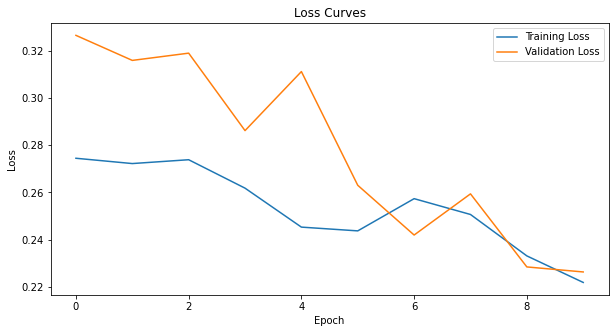

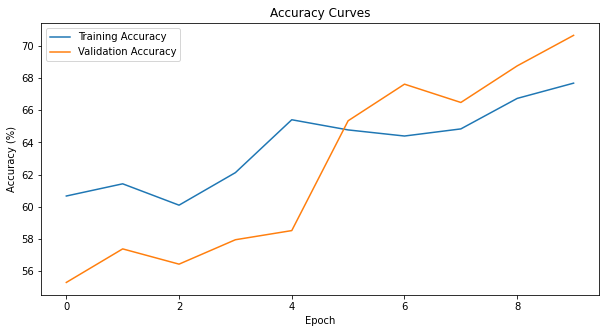

In [76]:
# Add generated images to the dataset
generated_image_paths = [os.path.join(generated_image_dir, img) for img in os.listdir(generated_image_dir)]
combined_genuine_images = all_genuine_images + generated_image_paths

# Update the datasets and loaders
train_dataset = SignatureDataset(combined_genuine_images, train_forged_images, root_dir, train_transform)
val_dataset = SignatureDataset(val_genuine_images, val_forged_images, root_dir, transform)
test_dataset = SignatureDataset(test_genuine_images, test_forged_images, root_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ContrastiveLoss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Instantiate the loss function
criterion = ContrastiveLoss().cuda()
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=0.0001)

# Training Loop
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
        
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance > 0.5).float()
        correct += (predictions == label.float()).sum().item()
        total += label.size(0)
        
        if batch_idx % 100 == 99:
            print(f'Epoch [{epoch+1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label.float())
            running_loss += loss.item()
            
            # Calculate accuracy
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance > 0.5).float()
            correct += (predictions == label.float()).sum().item()
            total += label.size(0)
    
    accuracy = 100 * correct / total
    return running_loss / len(val_loader), accuracy

# Training and Validation
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(siamese_net, train_loader, criterion, optimizer, epoch)
    val_loss, val_accuracy = validate(siamese_net, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Evaluation
def evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance > 0.5).float()
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate(siamese_net, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{cm}')

# Plotting the Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plotting the Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.show()


### Evaluation

In [54]:
# Define models
models = {
    'CNetOptimised': CNetOptimised(),
    'AlexNet': AlexNet(),
    'ResNet50': ResNet50(),
    'VGG19Model': VGG19Model(),
    'SiameseNetwork': SiameseNetwork()
}

# Define the test accuracies
test_accuracies = {
    'CNetOptimised': accuracy_test/100.0,
    'AlexNet': test_accuracy_alex,
    'ResNet50': test_accuracy_res,
    'VGG19Model': test_accuracy,
    'SiameseNetwork': accuracy
}

# Identify the best model based on test accuracy
best_model_name = None
best_accuracy = 0
best_model = None

for model_name, model in models.items():
    model_accuracy = test_accuracies[model_name]
    print(f'{model_name} Test Accuracy: {model_accuracy:.4f}')
    
    if model_accuracy > best_accuracy:
        best_accuracy = model_accuracy
        best_model_name = model_name
        best_model = model

print(f'Best model: {best_model_name} with accuracy: {best_accuracy:.4f}')


CNetOptimised Test Accuracy: 0.7355
AlexNet Test Accuracy: 0.7992
ResNet50 Test Accuracy: 0.9583
VGG19Model Test Accuracy: 0.9432
SiameseNetwork Test Accuracy: 0.6136
Best model: ResNet50 with accuracy: 0.9583


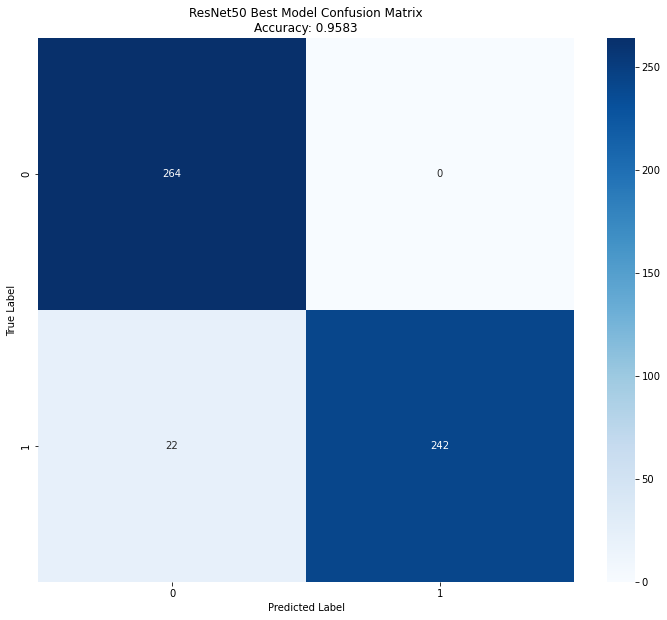

In [58]:
# Plot the best model's confusion matrix
if all_predictions_res and all_labels_res:
    conf_matrix = confusion_matrix(all_labels_res, all_predictions_res)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{best_model_name} Best Model Confusion Matrix\nAccuracy: {best_accuracy:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [59]:
# Save the best model
torch.save(best_model.state_dict(), f'best_model_{best_model_name}.pth')
print(f'Best model {best_model_name} saved as best_model_{best_model_name}.pth')


Best model ResNet50 saved as best_model_ResNet50.pth


In [60]:
model_path = 'siamese_network.pth'
torch.save(siamese_net.state_dict(), model_path)
print(f'Model saved to {model_path}')


Model saved to siamese_network.pth


### NOVELLTY

In [26]:
import os
import pickle
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Define the paths to your dataset
base_path_org = 'signatures/full_org/original_%d_%d.png'
base_path_forg = 'signatures/full_forg/forgeries_%d_%d.png'

# Define the image transformations for ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to fix pairs of indices to avoid duplicates
def fix_pair(x, y):
    while x == y:
        y = random.randrange(1, 24)
    return x, y

# Generate the dataset
data = []
n_samples_of_each_class = 13500

for _ in range(n_samples_of_each_class):
    anchor_person = random.randrange(1, 55)
    anchor_sign = random.randrange(1, 24)
    pos_sign = random.randrange(1, 24)
    anchor_sign, pos_sign = fix_pair(anchor_sign, pos_sign)
    neg_sign = random.randrange(1, 24)
    positive = [base_path_org % (anchor_person, anchor_sign), base_path_org % (anchor_person, pos_sign), 1]
    negative = [base_path_org % (anchor_person, anchor_sign), base_path_forg % (anchor_person, neg_sign), 0]
    data.append(positive)
    data.append(negative)

# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.15)

# Save the indices
with open('train_index.pkl', 'wb') as train_index_file:
    pickle.dump(train, train_index_file)

with open('test_index.pkl', 'wb') as test_index_file:
    pickle.dump(test, test_index_file)

# Custom Dataset class for training
class SignaturesDataset(Dataset):
    def __init__(self, index_file):
        with open(index_file, 'rb') as f:
            self.pairs = pickle.load(f)

    def __getitem__(self, index):
        item = self.pairs[index]
        X = Image.open(item[0]).convert('RGB')
        Y = Image.open(item[1]).convert('RGB')
        X = transform(X)
        Y = transform(Y)
        return [X, Y, item[2]]

    def __len__(self):
        return len(self.pairs)

# Create datasets and data loaders
train_dataset = SignaturesDataset('train_index.pkl')
test_dataset = SignaturesDataset('test_index.pkl')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Siamese Network with ResNet50
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

    def forward_one(self, x):
        return self.resnet(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  	(label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        img1, img2, label = batch
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Testing the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        img1, img2, label = batch
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
        output1, output2 = model(img1, img2)
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        predicted = (euclidean_distance < 0.5).float()
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0285
Epoch [2/10], Loss: 0.0010
Epoch [3/10], Loss: 0.0008
Epoch [4/10], Loss: 0.0157
Epoch [5/10], Loss: 0.0130
Epoch [6/10], Loss: 0.0028
Epoch [7/10], Loss: 0.0054
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0046
Accuracy: 95.19%


In [31]:
# Testing the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        img1, img2, label = batch
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
        output1, output2 = model(img1, img2)
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        predicted = (euclidean_distance < 0.5).float()
        total += label.size(0)
        correct += (predicted == label).sum().item()
        all_labels.extend(label.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 95.19%


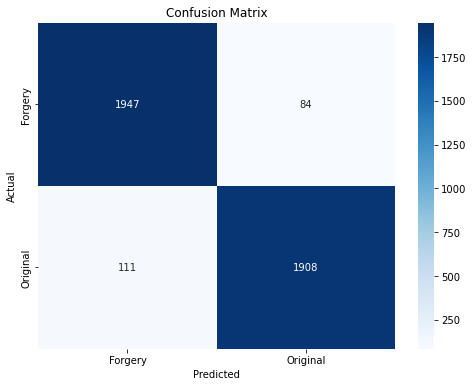

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds, target_names=['Forgery', 'Original'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Original'], yticklabels=['Forgery', 'Original'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
